# 地理空间数据--栅格
## 使用 Python 和 Xarray 打开、绘制和浏览栅格数据
通过学习我们知道栅格数据则是像素矩阵或者是单元格的集合，形成一张图片。
我们本节课的学习目标是：  
（1）Python 打开、绘制和浏览栅格数据。  
（2）处理栅格数据中的N/A值。  
（3）创建图范围，以便可以使用 matplotlib 同时绘制栅格和矢量数据。  
（4）使用直方图描述栅格数据特性。

## 1 Python 打开、绘制和浏览栅格数据。
**（1）导入要用的包**

In [ ]:
!pip install rioxarray

In [1]:
# Import necessary packages
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and xarray for raster data
import geopandas as gpd
import rioxarray as rxr

import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

**(2) 使用rioxarray打开tif文件**   
**rxr.open_rasterio**

In [3]:
dtm_pre_arr = rxr.open_rasterio("../earth-analytics/lidar/pre_DTM.tif")
dtm_pre_arr

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

使用 xarray 或 rioxarray 打开栅格数据时，将创建一个.object，它用来存储：数字像素数组格式的栅格数据；空间元数据，包括CRS，对象的空间范围和任何其他的元数据。  

Xarray并提供一种处理栅格数据的有效方法，还支持 DASK 和并行处理，允许我们使用计算机上的处理能力更有效地处理更大的数据集。

下面我们查看刚刚在上面打开的数据的坐标参考系（CRS）和空间范围。

In [4]:
# View the Coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:", dtm_pre_arr.rio.crs)
print("The spatial extent is:", dtm_pre_arr.rio.bounds())

The CRS for this data is: EPSG:32613
The spatial extent is: (472000.0, 4434000.0, 476000.0, 4436000.0)


In [5]:
# View no data value
print("The no data value is:", dtm_pre_arr.rio.nodata)

The no data value is: -3.4028235e+38


导入数据后，我们可以使用.plot()绘图

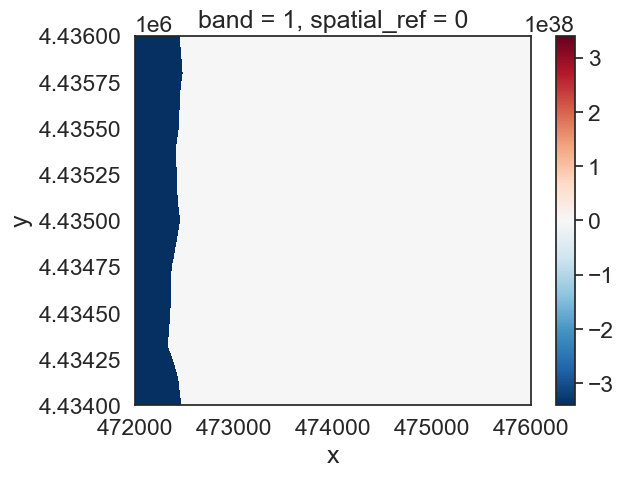

In [6]:
dtm_pre_arr.plot()
plt.show()

上述数据应代表地形模型数据。但是，值的范围不是预期的。这些数据适用于科罗拉多州的博尔德，其海拔范围可能在 1000-3000 米之间。数据中可能存在一些可能需要解决的异常值。下面，我们可以通过绘制直方图来查看数据中像素值的分布。  

## 2 处理栅格数据中的N/A值。
请注意，该图中的负范围内似乎有很多像素值。

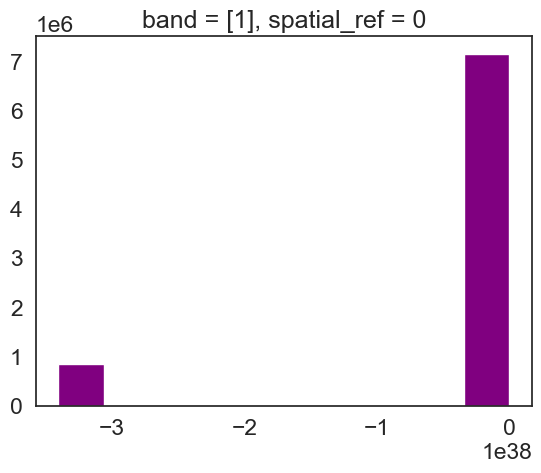

In [7]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
dtm_pre_arr.plot.hist(color="purple")
plt.show()

查看数据的最小值和最大值，我们可以看到最小值的非常小的负数。此数字与我们在上面查看的 no data 值匹配。

In [10]:
print("the minimum raster value is: ", np.nanmin(dtm_pre_arr.values))
print("the maximum raster value is: ", np.nanmax(dtm_pre_arr.values))

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


## 3 栅格数据浏览 - 最小值和最大值

从数据的最小值来看，有两件事需要解决：  
（1）数据中no data值可能会影响绘图颜色
（2）栅格中也可能存在异常数据  
我们可以先来探索（1）：通过使用如下函数读取数据并屏蔽 no data 值来 
**rxr.open_rasterio(dem_pre_path, masked=True)**  

上面我们还能还注意到，数组有一个额外的“波段”。虽然栅格只有一个图层，但输出中有一个 1 可能会妨碍处理。
我们可以使用 **.squeeze()** 删除该附加维度

In [11]:
# Notice that the shape of this object has a 1 at the beginning
# This can cause issues with plotting
dtm_pre_arr.shape

(1, 2000, 4000)

In [13]:
# Open the data and mask no data values
# Squeeze reduces the third dimension given there is only one "band" or layer to this data
dtm_pre_arr = rxr.open_rasterio("../earth-analytics/lidar/pre_DTM.tif", masked=True).squeeze()
# Notice there are now only 2 dimensions to your array
dtm_pre_arr.shape

(2000, 4000)

再次绘制数据以查看发生了哪些更改。现在，我们已经有了合理的数据值范围和数据绘图，绘制的图很漂亮。

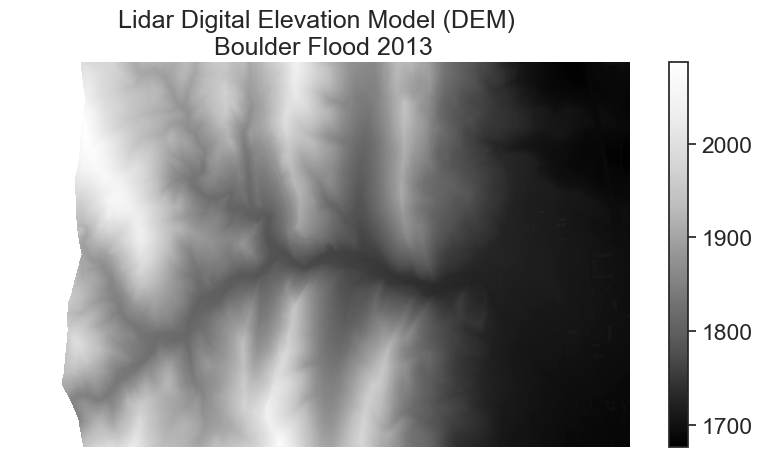

In [15]:
# Plot the data and notice that the scale bar looks better
# No data values are now masked
f, ax = plt.subplots(figsize=(10, 5))
dtm_pre_arr.plot(cmap="Greys_r",
                 ax=ax)
ax.set_title("Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013")
ax.set_axis_off()
plt.show()

直方图也发生了变化。现在，它显示了像素值的合理分布。

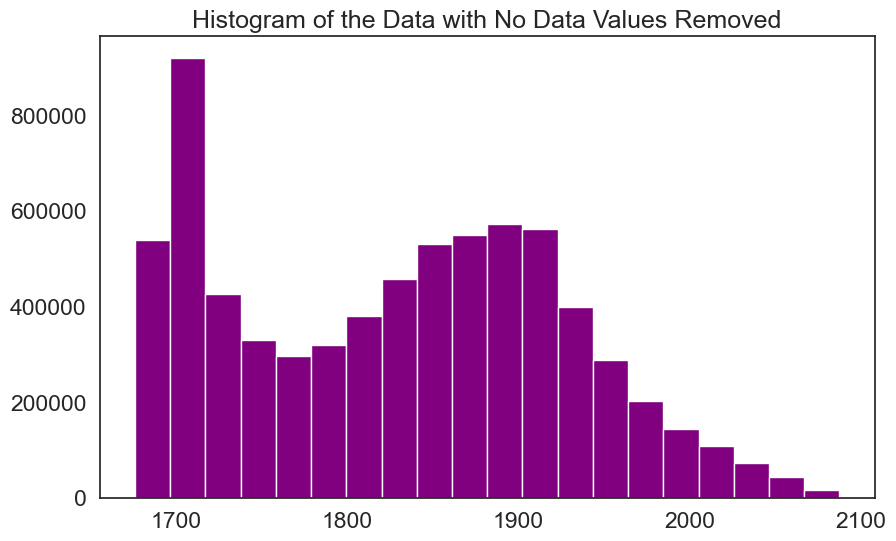

In [16]:
f, ax = plt.subplots(figsize=(10, 6))
dtm_pre_arr.plot.hist(color="purple",
                      bins=20)
ax.set_title("Histogram of the Data with No Data Values Removed")
plt.show()

请注意，现在最小值看起来更像是高程值（通常不应为负值）。

In [18]:
print("The minimum raster value is: ", np.nanmin(dtm_pre_arr.data))
print("The maximum raster value is: ", np.nanmax(dtm_pre_arr.data))

The minimum raster value is:  1676.21
The maximum raster value is:  2087.43


## 4 同时绘制栅格和矢量数据

如果需要，还可以将 shapefile 叠加添加到栅格数据图中。  
下面使用 Geopandas 打开单个形状文件，其中包含可叠加在栅格数据集顶部的边界图层。

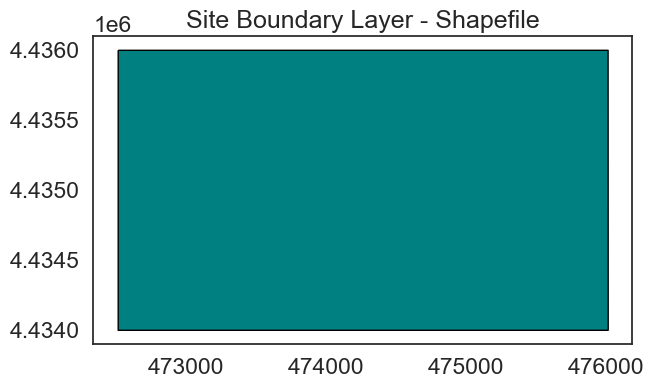

In [21]:
# Open site boundary vector layer

site_bound_shp = gpd.read_file("../earth-analytics/lidar/clip-extent.shp")

# Plot the vector data
f, ax = plt.subplots(figsize=(8,4))
site_bound_shp.plot(color='teal',
                    edgecolor='black',
                    ax=ax)
ax.set(title="Site Boundary Layer - Shapefile")
plt.show()

打开 shapefile 后，可以将两个数据集一起绘制并开始创建地图

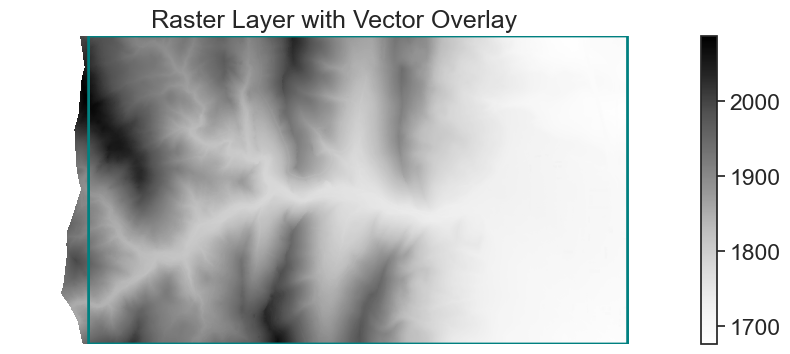

In [22]:
f, ax = plt.subplots(figsize=(11, 4))

dtm_pre_arr.plot.imshow(cmap="Greys",
                        ax=ax)
site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax,
                    zorder=4)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
plt.show()